# Training the simplest model

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import GlobalAvgPool1D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tqdm import tqdm


In [5]:
df = pd.read_csv('concat_reviews.csv')
df.dropna(inplace=True)


<ipython-input-5-3ccc71f4d1ed>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/concat.csv')


In [6]:
df.drop(columns=['dataset', 'original_index', 'review_text', 'rating', 'kfold_polarity', 'kfold_rating'], inplace=True)
df.reset_index(drop=True, inplace=True)
df


,review_text_processed,review_text_tokenized,polarity
0,bem macio e felpudo...recomendo. preco imbati...,"['bem', 'macio', 'felpudo', 'recomendo', 'prec...",1.0
1,produto excepcional! recomendo!!! inovador e ...,"['produto', 'excepcional', 'recomendo', 'inova...",1.0
2,recebi o produto antes do prazo mas veio com d...,"['recebi', 'produto', 'antes', 'do', 'prazo', ...",0.0
3,bom custo beneficio. adequado para pessoas que...,"['bom', 'custo', 'beneficio', 'adequado', 'par...",1.0
4,"otmo produto atendeu as expectativas, a entreg...","['otmo', 'produto', 'atendeu', 'as', 'expectat...",1.0
...,...,...,...
1196615,excelente custo-beneficio apresentado por este...,"['excelente', 'custo', 'beneficio', 'apresenta...",1.0
1196616,"game muito legal, com uma grande variedade de ...","['game', 'muito', 'legal', 'com', 'uma', 'gran...",1.0
1196617,"produto muito bom, simples e barato","['produto', 'muito', 'bom', 'simples', 'barato']",1.0
1196618,esse jogo e muito maneiro e um jogo onde vc te...,"['esse', 'jogo', 'muito', 'maneiro', 'um', 'jo...",1.0


In [7]:
df['polarity'] = df['polarity'].astype(int)


In [8]:
# Removing the largest reviews
top_50_largest_strings = df['review_text_processed'].str.len().nlargest(750).index
df = df.drop(top_50_largest_strings)
df.reset_index(drop=True, inplace=True)


In [9]:
df['polarity'].value_counts()


1    924006
0    271864
Name: polarity, dtype: int64

In [10]:
df['final'] = np.zeros(len(df))


In [11]:
for i in tqdm(range(len(df))):
    df['final'].iloc[i] = " ".join(eval(df['review_text_tokenized'].iloc[i]))


  0%|          | 0/1195870 [00:00<?, ?it/s]<ipython-input-11-daeda1aae0ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['final'].iloc[i] = " ".join(eval(df['review_text_tokenized'].iloc[i]))
100%|██████████| 1195870/1195870 [02:59<00:00, 6646.85it/s]


In [12]:
X = df['final']  # Features
y = df['polarity']  # Target variable


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)


In [15]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [16]:
maxlen = 500  # Maximum length of the review
X_train = pad_sequences(X_train, maxlen=maxlen, padding='pre')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='pre')


In [17]:
# Callback to save the weights of the best model based on the validation accuracy
class SaveBestModel(Callback):
    def __init__(self,filepath_weights):
        super(SaveBestModel, self).__init__()
        self.filepath_weights = filepath_weights
        self.best_acc = 0.

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs['val_binary_accuracy']
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.model.save_weights(f"{self.filepath_weights}_{(self.best_acc * 100) :.2f}.h5", overwrite=True)
            print(f"\nModel saved with validation accuracy: {val_acc:.4f}")


In [18]:
# Creating the Model
model = Sequential()
model.add(Embedding(num_words, 16, input_length=maxlen))
model.add(Dropout(0.2))
model.add(GlobalAvgPool1D())
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

opt = tf.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           160000    
                                                                 
 dropout (Dropout)           (None, 500, 16)           0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='binary_accuracy', mode='auto', patience=5,
                                                  restore_best_weights=True)


In [20]:
epochs = 150
hist = model.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, SaveBestModel(filepath_weights='model_weights')],
                 batch_size=128)


Epoch 1/150
7475/7475 [==============================] - ETA: 0s - loss: 0.4143 - binary_accuracy: 0.8153
Model saved with validation accuracy: 0.8776
7475/7475 [==============================] - 125s 16ms/step - loss: 0.4143 - binary_accuracy: 0.8153 - val_loss: 0.2920 - val_binary_accuracy: 0.8776
Epoch 2/150
7475/7475 [==============================] - ETA: 0s - loss: 0.2681 - binary_accuracy: 0.8939
Model saved with validation accuracy: 0.9064
7475/7475 [==============================] - 44s 6ms/step - loss: 0.2681 - binary_accuracy: 0.8939 - val_loss: 0.2436 - val_binary_accuracy: 0.9064
Epoch 3/150
7475/7475 [==============================] - ETA: 0s - loss: 0.2425 - binary_accuracy: 0.9088
Model saved with validation accuracy: 0.9171
7475/7475 [==============================] - 43s 6ms/step - loss: 0.2425 - binary_accuracy: 0.9088 - val_loss: 0.2337 - val_binary_accuracy: 0.9171
Epoch 4/150
7475/7475 [==============================] - 42s 6ms/step - loss: 0.2329 - binary_accurac

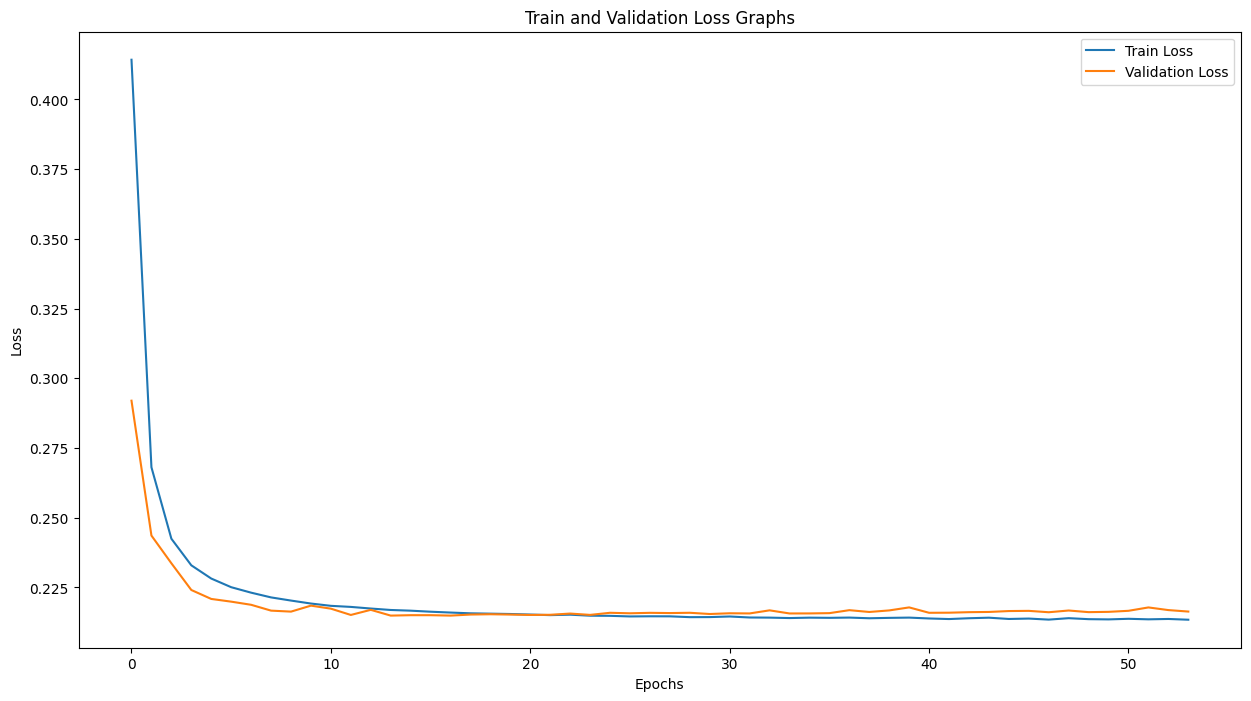

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss Graphs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


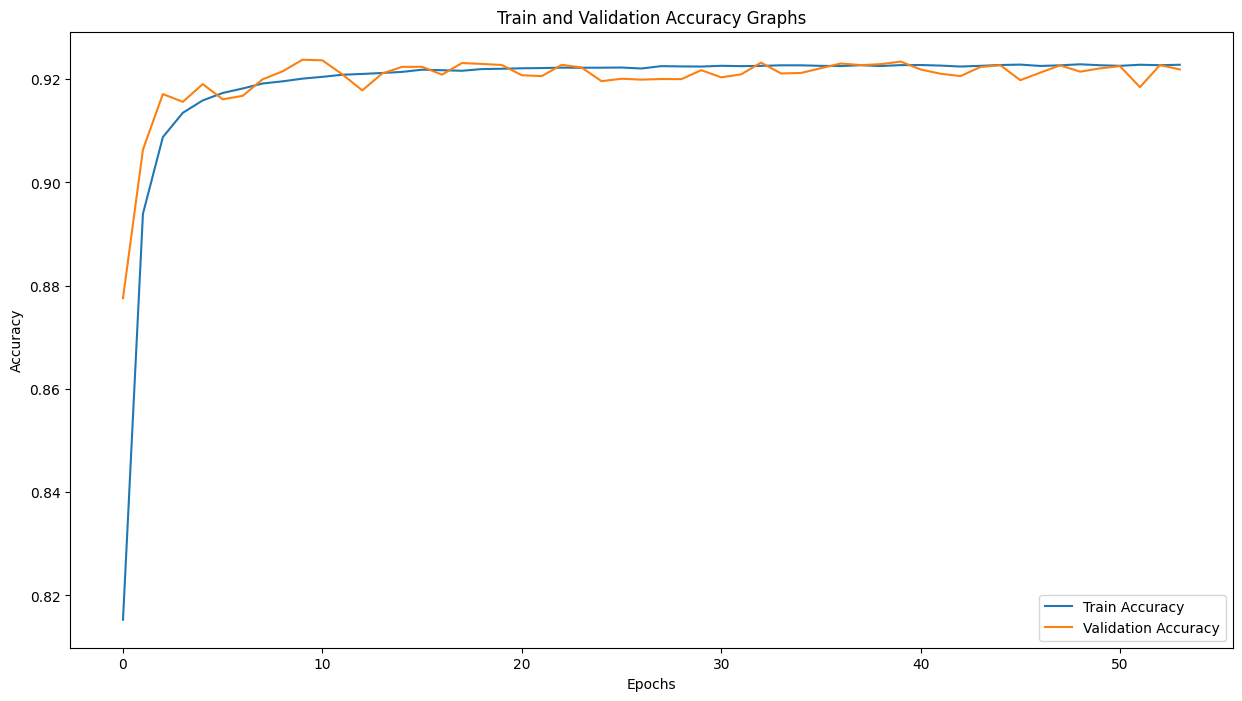

In [22]:
plt.figure(figsize=(15, 8))
plt.plot(hist.history['binary_accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy Graphs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


The others models were trained with the same "script", but changing the architecture and parameters.